In [1]:
import itertools
from cwgp.grid_search import grid_search
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import copy
import GPy
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os
import scipy

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def exp(x, *par):
    return par[0]*np.exp(par[1]*x)

In [4]:
def poly(x, *par):
    return np.polyval(par,x)

In [5]:
def log(x, *par):
    return par[0]*np.log(x)

In [6]:
def const(x, *par):
    return 0

In [17]:
def cwgp_regression(x_train, y_train, cwgp_model, **kwargs):
    kernel = GPy.kern.RBF(1)


    res = scipy.optimize.curve_fit(poly,  np.ravel(x_train), np.ravel(y_train), p0=(-1,-1), maxfev=3000)
    par = res[0]
    print(f"params:{par}")
    mf = GPy.core.Mapping(1,1)
    mf.f = lambda x: poly(x, *par)
    mf.update_gradients = lambda a,b: None


    model = GPy.models.GPRegression(x_train, y_train, mean_function=mf, kernel=kernel)
    model.optimize()

    
    start, end = 1940, 2031
    start_align = 1947-start
    domain_discrete = np.arange(start, end).reshape(-1,1)
    y_all = model.predict(domain_discrete)
    y_mean,y_var = y_all[0],y_all[1]
    y_top, y_bot = y_mean + 1.96*np.sqrt(y_var), y_mean - 1.96*np.sqrt(y_var)

    for cwgp in cwgp_model[::-1]:
        y_train = cwgp.phi.inv_comp_phi(cwgp.phi.res.x, y_train)
        y_mean, y_var = cwgp.phi.inv_comp_phi(cwgp.phi.res.x, y_mean), cwgp.phi.inv_comp_phi(cwgp.phi.res.x, y_var)
        y_top, y_bot = cwgp.phi.inv_comp_phi(cwgp.phi.res.x, y_top), cwgp.phi.inv_comp_phi(cwgp.phi.res.x, y_bot)

    print()

    validate_rmse = mean_squared_error(y_val, y_mean[train_up+start_align:train_up+start_align+validate], squared=False)
    validate_mae = mean_absolute_error(y_val, y_mean[train_up+start_align:train_up+start_align+validate])
    test_rmse = mean_squared_error(y_test, y_mean[train_up+start_align+validate:train_up+start_align+validate+test], squared=False)
    test_mae = mean_absolute_error(y_test, y_mean[train_up+start_align+validate:train_up+start_align+validate+test])
    txt = f"""validate rmse : {validate_rmse} \n validate mae : {validate_mae} \n
    test rmse : {test_rmse} \n test mae : {test_mae}"""

    name = [f"{cwgp.phi.fn.__name__}_{cwgp.phi.n}" for cwgp in cwgp_model]
    name = "_".join(name)
    domain = np.linspace(1940,2030,91)
    plt.fill_between(domain, np.ravel(y_top), np.ravel(y_bot), color=(0,0.5,0.5,0.2), label="Confidence")
    plt.scatter(x_train,y_train, marker="x", color='black', label="data")
    plt.scatter(x_val,y_val, marker="x", color='red', label="validate")
    plt.scatter(x_test, y_test, marker="x", color='blue', label="test")
    plt.plot(np.linspace(1940,2030,91),y_mean, label="mean")
    plt.ylim([0.1,0.35])
    plt.legend()
    plt.figtext(0.5, 0.2, txt, wrap=True, horizontalalignment='center', fontsize=12)
    plt.grid(True)
    plt.show()
        


    print(txt)
    return txt

In [8]:
CSV_FIlE = "../japan3.csv"
df = pd.read_csv(CSV_FIlE)
age = 90
df_all = {}
df_all[age]= df[(df["age"]==age)]

year = df_all[age]["year"].to_numpy().reshape(-1,1)
rate = df_all[age]["rate"].to_numpy().reshape(-1,1)


In [9]:
train_ratio, validate_ratio, test_ratio = 0.8, 0.1, 0.1
length = len(rate)

train, validate, test = int(train_ratio*length), int(validate_ratio*length), int(test_ratio*length)
train_up, train_low = train, train-train

In [10]:
x_train, y_train = year[train_low:train_up],rate[train_low:train_up]
x_val, y_val = year[train_up:train_up+validate],rate[train_up:train_up+validate]
x_test, y_test = year[train_up+validate:],rate[train_up+validate:]

  0%|          | 0/1296 [00:00<?, ?it/s]

[('sa', 1), ('sa', 2), ('sal', 1), ('sal', 2), ('box_cox', 1), ('box_cox', 2)]
(('sa', 1), ('sa', 1), ('sa', 1), ('sa', 1))
params:[-8.20155116e-02  1.61944444e+02]



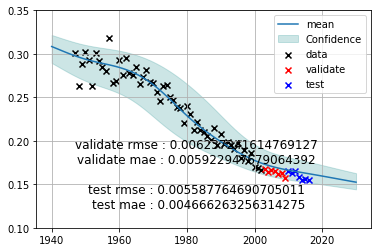

  0%|          | 1/1296 [00:00<15:36,  1.38it/s]

validate rmse : 0.006237241614769127 
 validate mae : 0.005922947679064392 

    test rmse : 0.005587764690705011 
 test mae : 0.004666263256314275
(('sa', 1), ('sa', 1), ('sa', 1), ('sa', 2))
params:[-8.20155237e-02  1.61944468e+02]



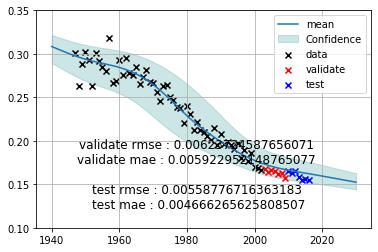

  0%|          | 2/1296 [00:01<17:44,  1.22it/s]

validate rmse : 0.00623724587656071 
 validate mae : 0.005922952148765077 

    test rmse : 0.00558776716363183 
 test mae : 0.004666265625808507
(('sa', 1), ('sa', 1), ('sa', 1), ('sal', 1))
params:[-1.08349893e-01  2.13943155e+02]



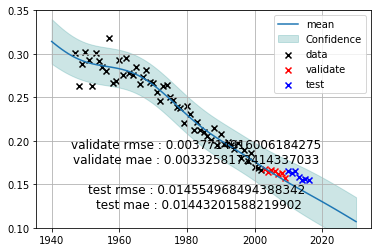

  0%|          | 3/1296 [00:04<33:23,  1.55s/it]

validate rmse : 0.0037714916006184275 
 validate mae : 0.0033258172414337033 

    test rmse : 0.014554968494388342 
 test mae : 0.01443201588219902
(('sa', 1), ('sa', 1), ('sa', 1), ('sal', 2))
params:[-1.13944215e-01  2.25210919e+02]



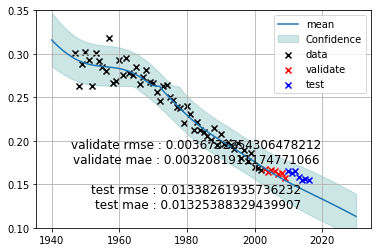

  0%|          | 4/1296 [00:10<1:17:13,  3.59s/it]

validate rmse : 0.0036732254306478212 
 validate mae : 0.0032081911174771066 

    test rmse : 0.01338261935736232 
 test mae : 0.01325388329439907
(('sa', 1), ('sa', 1), ('sa', 1), ('box_cox', 1))
params:[-8.61786951e-02  1.69067285e+02]



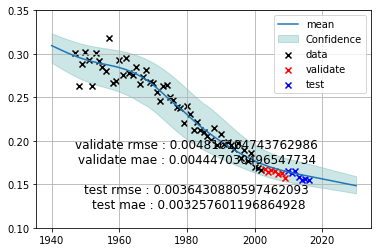

  0%|          | 5/1296 [00:11<56:06,  2.61s/it]  

validate rmse : 0.004816104743762986 
 validate mae : 0.004447030496547734 

    test rmse : 0.0036430880597462093 
 test mae : 0.003257601196864928
(('sa', 1), ('sa', 1), ('sa', 1), ('box_cox', 2))
params:[-8.41239211e-02  1.63879176e+02]



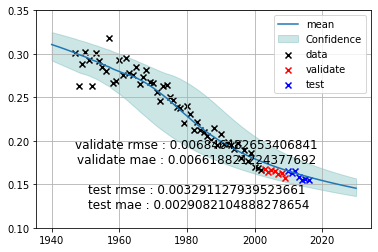

  0%|          | 6/1296 [00:12<41:25,  1.93s/it]

validate rmse : 0.006846482653406841 
 validate mae : 0.006618821224377692 

    test rmse : 0.003291127939523661 
 test mae : 0.0029082104888278654
(('sa', 1), ('sa', 1), ('sa', 2), ('sa', 1))
params:[-8.20155075e-02  1.61944438e+02]



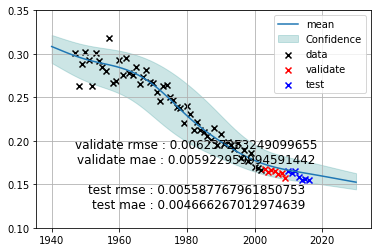

  1%|          | 7/1296 [00:13<33:37,  1.57s/it]

validate rmse : 0.006237253249099655 
 validate mae : 0.005922959994591442 

    test rmse : 0.005587767961850753 
 test mae : 0.004666267012974639
(('sa', 1), ('sa', 1), ('sa', 2), ('sa', 2))
params:[-8.20155378e-02  1.61944496e+02]



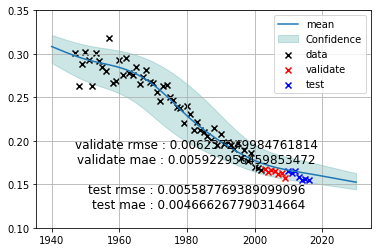

  1%|          | 8/1296 [00:13<29:07,  1.36s/it]

validate rmse : 0.006237249984761814 
 validate mae : 0.005922956459853472 

    test rmse : 0.005587769389099096 
 test mae : 0.004666267790314664
(('sa', 1), ('sa', 1), ('sa', 2), ('sal', 1))
params:[-1.08232604e-01  2.13687521e+02]



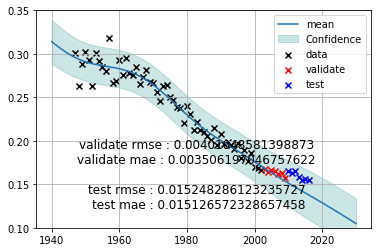

  1%|          | 9/1296 [00:17<46:28,  2.17s/it]

validate rmse : 0.00401048581398873 
 validate mae : 0.003506197046757622 

    test rmse : 0.015248286123235727 
 test mae : 0.015126572328657458
(('sa', 1), ('sa', 1), ('sa', 2), ('sal', 2))
params:[-1.07439947e-01  2.12171920e+02]



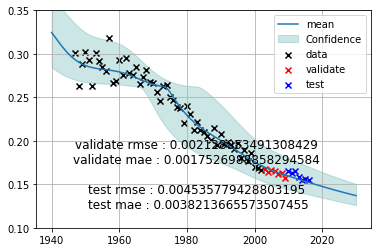

  1%|          | 10/1296 [00:25<1:23:57,  3.92s/it]

validate rmse : 0.002128853491308429 
 validate mae : 0.0017526988858294584 

    test rmse : 0.004535779428803195 
 test mae : 0.0038213665573507455
(('sa', 1), ('sa', 1), ('sa', 2), ('box_cox', 1))
params:[-8.61787064e-02  1.69067307e+02]



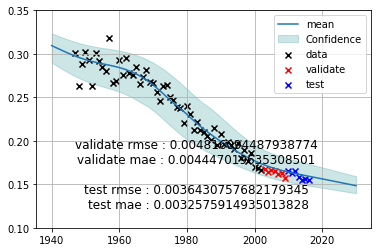

  1%|          | 11/1296 [00:26<1:03:00,  2.94s/it]

validate rmse : 0.004816094487938774 
 validate mae : 0.004447019635308501 

    test rmse : 0.0036430757682179345 
 test mae : 0.0032575914935013828
(('sa', 1), ('sa', 1), ('sa', 2), ('box_cox', 2))
params:[-8.41238931e-02  1.63879122e+02]



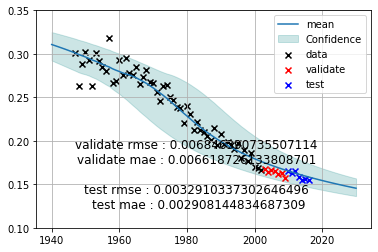

  1%|          | 12/1296 [00:27<48:48,  2.28s/it]  

validate rmse : 0.006846390735507114 
 validate mae : 0.006618726133808701 

    test rmse : 0.0032910337302646496 
 test mae : 0.002908144834687309
(('sa', 1), ('sa', 1), ('sal', 1), ('sa', 1))
params:[-1.08332236e-01  2.13940276e+02]



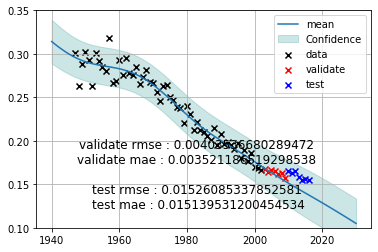

  1%|          | 13/1296 [00:29<51:37,  2.41s/it]

validate rmse : 0.00403536680289472 
 validate mae : 0.003521186519298538 

    test rmse : 0.01526085337852581 
 test mae : 0.015139531200454534
(('sa', 1), ('sa', 1), ('sal', 1), ('sa', 2))
params:[-1.08294588e-01  2.13857339e+02]



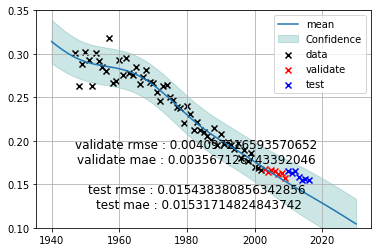

  1%|          | 14/1296 [00:31<48:22,  2.26s/it]

validate rmse : 0.004097216593570652 
 validate mae : 0.003567126743392046 

    test rmse : 0.015438380856342856 
 test mae : 0.01531714824843742
(('sa', 1), ('sa', 1), ('sal', 1), ('sal', 1))
params:[-1.06351320e-01  2.09866619e+02]



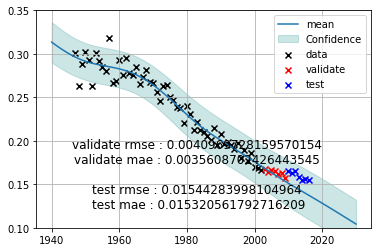

  1%|          | 15/1296 [00:35<54:34,  2.56s/it]

validate rmse : 0.0040969728159570154 
 validate mae : 0.0035608702426443545 

    test rmse : 0.01544283998104964 
 test mae : 0.015320561792716209
(('sa', 1), ('sa', 1), ('sal', 1), ('sal', 2))


In [ ]:
result = grid_search(cwgp_regression, x_train, y_train, {"c":4,"n":[1,2],"transformations":["sa","sal","box_cox"]},
                    x_val=x_val,y_val=y_val,
                    x_test=x_test,y_test=y_test
                    )

In [ ]:
sa1sa1sa1bc2(-8.39185469e-02  1.63633232e+02)